In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import trange

***import image***

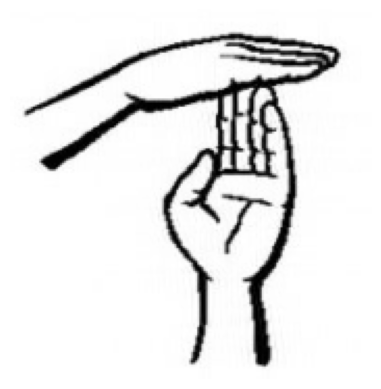

Image shape: (178, 174)


In [2]:
I = cv2.imread("sample1.png", 1)
I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
plt.imshow(I, cmap="gray")
plt.axis("off")
plt.show()
print("Image shape:", I.shape)

In [3]:
# I = cv2.resize(I,(160, 160))
# plt.imshow(I, cmap = "gray");plt.axis("off")
# I.shape

***Base function***

  0%|          | 0/8 [00:00<?, ?it/s]

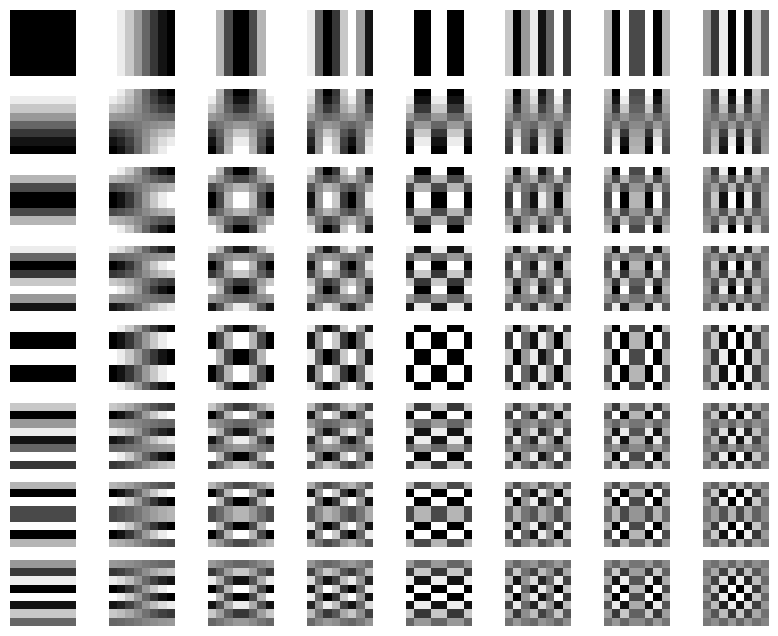

In [4]:
coef_base = np.zeros((8, 8, 8, 8))
for u in trange(8):
    for v in range(8):
        for x in range(8):
            for y in range(8):
                coef_base[u, v, x, y] = np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
fig, axes = plt.subplots(8, 8, figsize=(10, 8))
for u in range(8):
    for v in range(8):
        axes[u, v].imshow(coef_base[u, v], cmap="gray")
        axes[u, v].axis("off")
plt.show()

***Base quantizition***

In [5]:
def QQC(degree):
    newQ = np.zeros((8, 8), dtype=np.uint8)
    if 1 < degree < 50:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip((50 / degree) * Q[i, j], 0, 255)
        return newQ
    elif 50 < degree < 100:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip(((100 - degree) / 50) * Q[i, j], 0, 255)
        return newQ
    elif degree == 50:
        return Q
    else:
        return "sorry but not possible"

Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])


***Apply the DCT***

In [6]:
I[:8, :8]

array([[255, 255, 255, 255, 255, 255, 255, 255],
       [254, 254, 254, 254, 254, 254, 254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [7]:
num_blocks = (I.shape[0] // 8, I.shape[1] // 8)
blocks = np.empty((num_blocks[0], num_blocks[1], 8, 8))
for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
    for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
        blocks[i, j] = I[k:k + 8, l:l + 8]
width, height, _, _ = blocks.shape

In [8]:
blocks[0,0]

array([[255., 255., 255., 255., 255., 255., 255., 255.],
       [254., 254., 254., 254., 254., 254., 254., 254.],
       [254., 254., 254., 254., 254., 254., 254., 254.],
       [254., 254., 254., 254., 254., 254., 254., 254.],
       [254., 254., 254., 254., 254., 254., 254., 254.],
       [255., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255.]])

In [31]:
def DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr, dtype=np.float32)
    g_x = np.subtract(np.copy(arr), 128)
    for row in trange(width):
        for column in range(height):
            for u in range(8):
                for v in range(8):
                    sumGx = 0
                    for x in range(8):
                        for y in range(8):
                            au = np.sqrt(1/2) if u == 0 else 1
                            av = np.sqrt(1/2) if v == 0 else 1
                            sumGx += g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = (1/4) * au * av * sumGx
    return result

dctM = DCT(blocks)

  0%|          | 0/22 [00:00<?, ?it/s]

In [42]:
def quantizition(arr, Q):
    quant = QQC(Q)
    totest = np.copy(arr)
    finalStep = np.zeros_like(arr)
    for i in range(width):
        for j in range(height):
            for x in range(8):
                for y in range(8):
                    finalStep[i, j, x, y] = round(totest[i, j, x, y] / quant[x, y])
    return finalStep

qun = quantizition(dctM, 50)
print(np.round(dctM[0, 0], 3))
print(qun[0,0])


[[ 1.012e+03  0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00
  -0.000e+00 -0.000e+00]
 [-1.962e+00 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
   0.000e+00 -0.000e+00]
 [ 2.613e+00 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00 -0.000e+00
  -0.000e+00 -0.000e+00]
 [ 1.663e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00 -0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00 -0.000e+00  0.000e+00 -0.000e+00
   0.000e+00 -0.000e+00]
 [ 1.111e+00  0.000e+00  0.000e+00 -0.000e+00  0.000e+00 -0.000e+00
   0.000e+00 -0.000e+00]
 [ 1.082e+00  0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [-3.900e-01 -0.000e+00  0.000e+00 -0.000e+00  0.000e+00  0.000e+00
   0.000e+00 -0.000e+00]]
[[63.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 

***reconstruct by 30, 50 and 70***

In [33]:
def Iquantizition(arr, Q):
    quant = QQC(Q)
    totest = np.copy(arr)
    finalStep = np.zeros_like(arr)
    for i in range(width):
        for j in range(height):
            for x in range(8):
                for y in range(8):
                    finalStep[i, j, x, y] = round(totest[i, j, x, y] * quant[x, y])
    return finalStep

Iqun = Iquantizition(qun, 50)
print(Iqun[0, 0])


[[1008.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]]


In [34]:
def energy_left(arr, energy):
    qunP = np.copy(arr)
    leftEnergy = round(8*energy/100)
    for i in range(width):
        for j in range(height):
            qunP[i, j, leftEnergy:] = 0
            qunP[i, j, :, leftEnergy:] = 0
    return qunP
newImg_70 = energy_left(Iqun, 70)
newImg_50 = energy_left(Iqun, 50)
newImg_30 = energy_left(Iqun, 30)
newImg = energy_left(Iqun, 100)


***Apply the IDCT***

In [65]:
def inv_DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr, dtype=np.uint8)
    g_x = np.copy(arr)
    for row in trange(width):
        for column in range(height):
            for u in range(8):
                for v in range(8):
                    sum_val = 0
                    for x in range(8):
                        for y in range(8):
                            au = np.sqrt(1/2) if u == 0 else 1
                            av = np.sqrt(1/2) if v == 0 else 1
                            sum_val +=  g_x[row, column, x, y] * np.cos((2*x + 1) * u * np.pi / 16) * np.cos((2*y + 1) * v * np.pi / 16)
                    result[row, column, u, v] = au * av * (1/8) * sum_val
    result = np.add(result, 128)
    return result

In [62]:
inv_dct = inv_DCT(Iqun)


  0%|          | 0/22 [00:00<?, ?it/s]

In [66]:
inv_dct_30 = inv_DCT(newImg_30)
inv_dct_50 = inv_DCT(newImg_50)
inv_dct_70 = inv_DCT(newImg_70)
inv_dct = inv_DCT(Iqun)


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [67]:
def restord(img):
    cp = np.copy(img)
    new_Img = np.empty((I.shape[0], I.shape[1]), dtype = np.uint8)
    for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
        for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
            new_Img[k:k + 8, l:l + 8] = cp[i, j]
    return new_Img

In [68]:
new_Img = restord(inv_dct)
new_Img_30 = restord(inv_dct_30)
new_Img_50 = restord(inv_dct_50)
new_Img_70 = restord(inv_dct_70)

In [69]:
new_Img[0:13, 0:13]

array([[191, 215, 210, 202, 191, 177, 162, 145, 191, 215, 210, 202, 191],
       [215, 249, 242, 230, 215, 196, 175, 152, 215, 249, 242, 230, 215],
       [210, 242, 235, 224, 210, 192, 172, 150, 210, 242, 235, 224, 210],
       [202, 230, 224, 215, 202, 186, 168, 148, 202, 230, 224, 215, 202],
       [191, 215, 210, 202, 191, 177, 162, 145, 191, 215, 210, 202, 191],
       [177, 196, 192, 186, 177, 166, 154, 141, 177, 196, 192, 186, 177],
       [162, 175, 172, 168, 162, 154, 146, 137, 162, 175, 172, 168, 162],
       [145, 152, 150, 148, 145, 141, 137, 132, 145, 152, 150, 148, 145],
       [192, 216, 211, 203, 192, 178, 162, 145, 192, 216, 211, 203, 192],
       [216, 251, 243, 232, 216, 197, 176, 152, 216, 251, 243, 232, 216],
       [211, 243, 237, 226, 211, 193, 173, 151, 211, 243, 237, 226, 211],
       [203, 232, 226, 216, 203, 187, 168, 148, 203, 232, 226, 216, 203],
       [192, 216, 211, 203, 192, 178, 162, 145, 192, 216, 211, 203, 192]],
      dtype=uint8)

***Result***

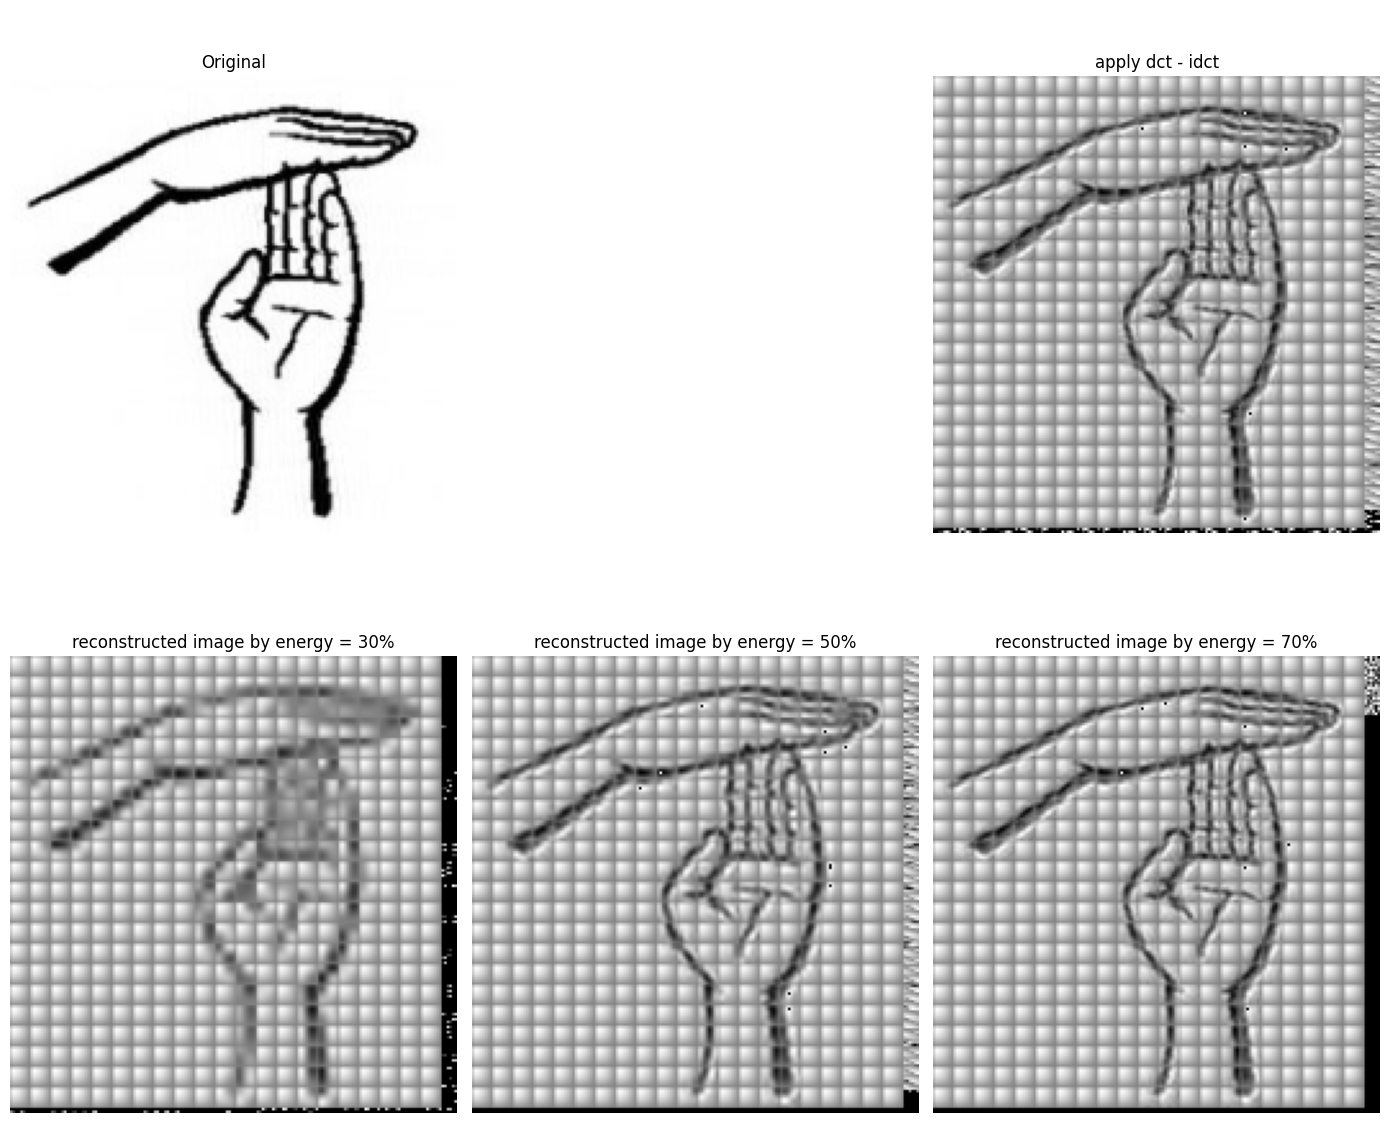

In [70]:
fig , axe = plt.subplots(nrows=2, ncols=3, figsize=(14, 12))
axe[0, 0].imshow(I, cmap="gray");axe[0, 0].axis("off");axe[0, 0].set_title("Original")
axe[0, 1].axis("off")
axe[0, 2].imshow(new_Img, cmap="gray");axe[0, 2].axis("off");axe[0, 2].set_title("apply dct - idct")
axe[1, 0].imshow(new_Img_30, cmap="gray");axe[1, 0].axis("off");axe[1, 0].set_title("reconstructed image by energy = 30%")
axe[1, 1].imshow(new_Img_50, cmap="gray");axe[1, 1].axis("off");axe[1, 1].set_title("reconstructed image by energy = 50%")
axe[1, 2].imshow(new_Img_70, cmap="gray");axe[1, 2].axis("off");axe[1, 2].set_title("reconstructed image by energy = 70%")
plt.tight_layout()
plt.show()

***Apply zig-zag order***

In [20]:
def zigzag(mat):
    index_order = sorted(((x, y) for x in range(8) for y in range(8)), key=lambda x: (x[0] + x[1], -x[1] if (x[0] + x[1]) % 2 else x[1]))
    arr = np.copy(mat)
    order_array = np.zeros((width, height, 64))
    for u in range(width):
        for v in range(height):
            order_array[u, v] = [arr[u, v, i, j] for i, j in index_order]
    return order_array

orderArray = zigzag(qun)

In [21]:
width_o, height_o, deep_o = orderArray.shape
DPCM = np.zeros_like(orderArray)
for x in range(width_o):
    for y in range(height_o) : 
        if x == 0 and y == 0 : DPCM[x, y, 0] = orderArray[x, y, 0]
        elif x == 0 :
            sub = orderArray[x, y - 1, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
        elif y == 0 :
            sub = orderArray[x - 1, y, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
        else:
            sub = orderArray[x - 1, y - 1, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
DPCM = np.round(DPCM)

In [22]:
ac = np.zeros_like(DPCM, dtype=object)
for x in range(width_o):
    for y in range(height_o):
        counter_zero = 0
        for z in range (deep_o):
            if  z == 0:  ac[x, y, z] =int(DPCM[x, y, 0])
            elif orderArray[x, y, z] == 0 : counter_zero+=1;continue
            else: 
                ac[x, y, z] = np.array([(counter_zero, int.bit_length(int(orderArray[x, y, z]))), int(orderArray[x, y, z])], dtype=object)
                counter_zero = 0
        if counter_zero != 0:ac[x, y, -counter_zero] = (0, 0)
        elif counter_zero == 63:ac[x, y, 1] = (0, 0)

In [23]:
# ac[17, 10]

In [24]:
def int_to_custom_binary(n,):
    if n == 0: return ""
    binary = bin(abs(n))[2:]  
    if n < 0:binary = binary.replace("0", "2").replace("1", "0").replace("2", "1")
    return binary

In [25]:
# ac[2, 14]

In [26]:
dc_huffman_tables = {
    0: "00",
    1: "010",
    2: "011",
    3: "100",
    4: "101",
    5: "110",
    6: "1110",
    7: "11110",
    8: "111110",
    9: "1111110",
    10: "11111110",
    11: "111111110"}
ac_huffman_tables = {
    (0, 1): '00',
    (0, 2): '01',
    (0, 3): '100',
    (0, 4): '1011',
    (0, 5): '11010',
    (0, 6): '1111000',
    (0, 7): '11111000',
    (0, 8): '1111110110',
    (0, 9): '1111111110000010',
    (0, 10): '1111111110000011',
    (1, 1): '1100',
    (1, 2): '11011',
    (1, 3): '1111001',
    (1, 4): '111110110',
    (1, 5): '11111110110',
    (1, 6): '1111111110000100',
    (1, 7): '1111111110000101',
    (1, 8): '1111111110000110',
    (1, 9): '1111111110000111',
    (1, 10): '1111111110001000',
    (2, 1): '11100',
    (2, 2): '11111001',
    (2, 3): '1111110111',
    (2, 4): '111111110100',
    (2, 5): '1111111110001001',
    (2, 6): '1111111110001010',
    (2, 7): '1111111110001011',
    (2, 8): '1111111110001100',
    (2, 9): '1111111110001101',
    (2, 10): '1111111110001110',
    (3, 1): '111010',
    (3, 2): '111110111',
    (3, 3): '111111110101',
    (3, 4): '1111111110001111',
    (3, 5): '1111111110010000',
    (3, 6): '1111111110010001',
    (3, 7): '1111111110010010',
    (3, 8): '1111111110010011',
    (3, 9): '1111111110010100',
    (3, 10): '1111111110010101',
    (4, 1): '111011',
    (4, 2): '1111111000',
    (4, 3): '1111111110010110',
    (4, 4): '1111111110010111',
    (4, 5): '1111111110011000',
    (4, 6): '1111111110011001',
    (4, 7): '1111111110011010',
    (4, 8): '1111111110011011',
    (4, 9): '1111111110011100',
    (4, 10): '1111111110011101',
    (5, 1): '1111010',
    (5, 2): '11111110111',
    (5, 3): '1111111110011110',
    (5, 4): '1111111110011111',
    (5, 5): '1111111110100000',
    (5, 6): '1111111110100001',
    (5, 7): '1111111110100010',
    (5, 8): '1111111110100011',
    (5, 9): '1111111110100100',
    (5, 10): '1111111110100101',
    (6, 1): '1111011',
    (6, 2): '111111110110',
    (6, 3): '1111111110100110',
    (6, 4): '1111111110100111',
    (6, 5): '1111111110101000',
    (6, 6): '1111111110101001',
    (6, 7): '1111111110101010',
    (6, 8): '1111111110101011',
    (6, 9): '1111111110101100',
    (6, 10): '1111111110101101',
    (7, 1): '11111010',
    (7, 2): '111111110111',
    (7, 3): '1111111110101110',
    (7, 4): '1111111110101111',
    (7, 5): '1111111110110000',
    (7, 6): '1111111110110001',
    (7, 7): '1111111110110010',
    (7, 8): '1111111110110011',
    (7, 9): '1111111110110100',
    (7, 10): '1111111110110101',
    (8, 1): '111111000',
    (8, 2): '111111111000000',
    (8, 3): '1111111110110110',
    (8, 4): '1111111110110111',
    (8, 5): '1111111110111000',
    (8, 6): '1111111110111001',
    (8, 7): '1111111110111010',
    (8, 8): '1111111110111011',
    (8, 9): '1111111110111100',
    (8, 10): '1111111110111101',
    (9, 1): '111111001',
    (9, 2): '1111111110111110',
    (9, 3): '1111111110111111',
    (9, 4): '1111111111000000',
    (9, 5): '1111111111000001',
    (9, 6): '1111111111000010',
    (9, 7): '1111111111000011',
    (9, 8): '1111111111000100',
    (9, 9): '1111111111000101',
    (9, 10): '1111111111000110',
    (10, 1): '111111010',
    (10, 2): "1111111111010000",
    (10, 3): "1111111111010001",
    (10, 4): "1111111111010010",
    (10, 5): "1111111111010011",
    (10, 6): "1111111111010100",
    (10, 7): "1111111111010101",
    (10, 8): "1111111111010110",
    (10, 9): "1111111111010111",
    (10, 10): "1111111111011000",
    (11, 1): "11111111000",
    (11, 2): "1111111111011001",
    (11, 3): "1111111111011010",
    (11, 4): "1111111111011011",
    (11, 5): "1111111111011100",
    (11, 6): "1111111111011101",
    (11, 7): "1111111111011110",
    (11, 8): "1111111111011111",
    (11, 9): "1111111111100000",
    (11, 10): "1111111111100001",
    (12, 1): "1111111111100010",
    (11, 8): "1111111111011111",
    (11, 9): "1111111111100000",
    (11, 10): "1111111111100001",
    (12, 1): "1111111111100010",
    (12, 2): "1111111111100011",
    (12, 3): "1111111111100100",
    (12, 4): "1111111111100101",
    (12, 5): "1111111111100110",
    (12, 6): "1111111111100111",
    (12, 7): "1111111111101000",
    (12, 8): "1111111111101001",
    (12, 9): "1111111111101010",
    (12, 10): "1111111111101011",
    (13, 1): "1111111111101100",
    (13, 2): "1111111111101101",
    (13, 3): "1111111111101110",
    (13, 4): "1111111111101111",
    (13, 5): "1111111111110000",
    (13, 6): "1111111111110001",
    (13, 7): "1111111111110010",
    (13, 8): "1111111111110011",
    (13, 9): "1111111111110100",
    (13, 10): "1111111111110101",
    (14, 1): "1111111111110110",
    (14, 2): "1111111111110111",
    (14, 3): "1111111111111000",
    (14, 4): "1111111111111001",
    (14, 5): "1111111111111010",
    (14, 6): "1111111111111011",
    (14, 7): "1111111111111100",
    (14, 8): "1111111111111101",
    (14, 9): "1111111111111110",
    (14, 10): "1111111111111111",
    (15, 0): "11111111001"}

In [27]:
import sys
sys.set_int_max_str_digits(99999999)

encode = np.zeros_like(ac, dtype = np.int64)
for x in range(width_o):
    for y in range(height_o):
        for z in range (deep_o):
            if z == 0: encode[x, y, z] = int(int_to_custom_binary(ac[x, y, z],) + dc_huffman_tables[int.bit_length(ac[0, 0, 0])])
            elif type(ac[x, y, z]) is tuple and ac[x, y, z] == (0, 0):encode[x, y, z] = 1010;break
            elif type(ac[x, y, z]) is not np.ndarray and ac[x, y, z] == 0  : continue
            else:
                if ac[x, y, z][0][0]>15:int("11111111001" + int_to_custom_binary(ac[x, y, z][1]))
                else:
                    try :
                        encode[x, y, z] = int(ac_huffman_tables[ac[x, y, z][0]] + int_to_custom_binary(ac[x, y, z][1]))
                    except:
                        print(ac[x, y, z])

[(2, 5) 24]
[(1, 7) 70]
[(1, 6) 42]
[(3, 6) -38]
[(3, 6) 59]
[(2, 6) -37]


In [28]:
class BinaryTreeNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
    def insert(self, valu):
        if valu < self.value:
            if self.left is None:
                self.left = BinaryTreeNode(valu)
            else:self.left.insert(valu)
        else:
            if self.right is None:
                self.right = BinaryTreeNode(valu)
            else:self.right.insert(valu)
    def printOrder(self):
        if self.left:
            return self.left.printOrder()
        print(self.value)
        if self.right:
            return self.right.printOrder()
tree = BinaryTreeNode(5)
tree.insert(6)
tree.insert(4)
# tree.insert(1)
tree.insert(6)
tree.insert(7)
tree.insert(8)
# tree.insert(3)
tree.printOrder()
# def orderT (tree):
#     if tree.left is not None:
#         return orderT (tree.left)
#     elif tree.right is not None:
#         return orderT(tree.right)
#     else: print (tree.value)
# orderT(tree)
# print(tree.right.value)

4


                5
        4               5
    1       3               6
                                7
                                    8

In [29]:
def left(t):
    if t.left != None:
        return od(t.left)
    return t
def right(t):
    if t.right != None:
        return od(t.right)
    return t
def vl(t):
    print(t.value)
def od(tree):
    node = left(tree)
    node = right(node)
    node = vl(node)
od(tree)
    

4


AttributeError: 'NoneType' object has no attribute 'right'